In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import manifold
from sklearn import model_selection, linear_model

# Load features and labels

`features.npy` contains a NumPy array of shape (number of images, number of features) = (35126, 2048)

`keys.npy` contains the corresponding image 'names' — the filenames without the .jpeg suffix. 

`trainLabels.csv` maps these names to the level of diabetic retinopathy (0 — No DR, 1 — Mild, 2 — Moderate', 3 — Severe, 4 — Proliferative).

In [3]:
keys = np.load('keys.npy')
features = np.load('features.npy')
sharpness = np.load('sharpness.npy')
labels_df = pd.read_csv('trainLabels.csv', index_col='image')

# Check lengths are the same for all raw data
len(keys), len(features), len(sharpness), len(labels_df)

(35126, 35126, 35126, 35126)

# Map image names to levels
Using an inner join.

In [4]:
features_df = pd.DataFrame(features, index=keys)
features_df['sharpness'] = sharpness
df = pd.merge(features_df, labels_df, how='inner', left_index=True, right_index=True)

In [5]:
df.head(4)

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,sharpness,level
10_left,0.526682,0.043948,0.042256,0.029524,0.425382,0.424015,0.007560,0.458355,0.099644,0.203269,...,0.088355,0.191702,0.202443,0.047101,0.340382,0.949681,0.095512,0.346594,11.919417,0
10_right,0.316538,0.064303,0.111772,0.015365,0.415922,0.678155,0.001650,1.000529,0.061218,0.207925,...,0.225751,0.339383,0.337852,0.251831,0.491701,0.638236,0.065918,0.579277,9.066678,0
13_left,0.404190,0.400065,0.017244,0.058396,0.542456,0.463827,0.244821,0.653481,0.175902,0.143579,...,0.257084,0.171873,0.019319,0.004694,0.102028,0.737695,0.232218,0.641074,14.193949,0
13_right,0.520057,0.271358,0.013167,0.005301,0.710363,0.430825,0.019369,0.618148,0.147279,0.079770,...,0.370906,0.084486,0.042817,0.014832,0.045585,0.765283,0.125689,0.619225,12.487727,0


# Distribution of DR levels
There are many more images with no diabetic retinopathy (level = 0) than those with.

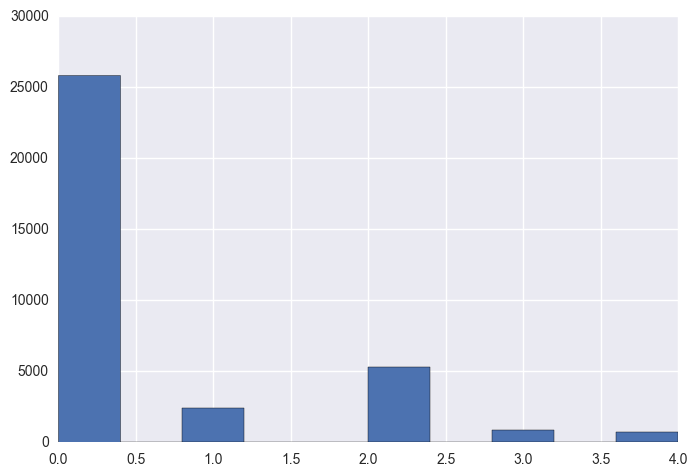

In [6]:
df.level.hist();

# Balance classes

First, recover features and labels as numpy arrays X and y suitable for `sklearn`.

In [7]:
feature_cols = df.columns[:-2] # only Inception v3 features
feature_cols = df.columns[:-1] # Inception v3 features + sharpness
X = df[feature_cols].values
y = df['level'].values
#s = df['sharpness'].values

X.shape, y.shape#, s.shape

((35126, 2049), (35126,))

Randomly sample to get equal samples in each of the five classes.

In [8]:
np.random.seed(42)
min_class = pd.Series(y).value_counts().min() # number of samples in smallest class
#min_class = 100 # reduced dataset size for speed
# all_idx[y==label] selects all elements in X & y where y == label
# np.random.choice chooses a random subset of these of size min_class
all_idx = np.arange(len(X))
bal_idx = np.ravel([np.random.choice(all_idx[y==label], size=min_class, replace=False) 
                    for label in set(y)])

# Balanced X and y
X_bal = X[bal_idx]
y_bal = y[bal_idx]
#s_bal = s[bal_idx]

# Check equal numbers of each level
pd.Series(y_bal).value_counts()

3    708
1    708
4    708
2    708
0    708
dtype: int64

# Visualize with t-SNE

I find t-SNE an excellent way to check if high-dimensional features separate into easily identifiable classes.

In [9]:
tsne = manifold.TSNE(n_components=2, init='random', perplexity=30, 
                     early_exaggeration=8, random_state=42, verbose=2)
X_tsne = tsne.fit_transform(X_bal)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3540
[t-SNE] Computed conditional probabilities for sample 2000 / 3540
[t-SNE] Computed conditional probabilities for sample 3000 / 3540
[t-SNE] Computed conditional probabilities for sample 3540 / 3540
[t-SNE] Mean sigma: 2.796067
[t-SNE] Iteration 25: error = 1.9307557, gradient norm = 0.0085648
[t-SNE] Iteration 50: error = 1.8253492, gradient norm = 0.0054434
[t-SNE] Iteration 75: error = 1.5590200, gradient norm = 0.0018105
[t-SNE] Iteration 100: error = 1.5128213, gradient norm = 0.0015361
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.512821
[t-SNE] Iteration 125: error = 1.4373329, gradient norm = 0.0011963
[t-SNE] Iteration 150: error = 1.4136711, gradient norm = 0.0010951
[t-SNE] Iteration 175: error = 1.4078240, gradient norm = 0.0010716
[t-SNE] Iteration 200: error = 1.4062644, gradient norm = 0.0010652
[t-SNE]

## Create DataFrame for plotting

In [10]:
legend_map = {0:'No DR', 1:'Mild', 2:'Moderate', 3:'Severe', 4:'Proliferative'}
f = np.vectorize(lambda x: legend_map[x])
df_tsne = pd.DataFrame({'x': X_tsne[:,0], 'y': X_tsne[:,1], 'Level': f(y_bal)})

## Plot
There are some clearly defined groups in the plot but unfortunately not great separation between the levels of diabetic retinopathy. On further investigation the well-separated groups correspond to different croppings of the original images and whether the image is inverted (some retina camera do this). 

The plot suggests that classifcation models will struggle to perform very well.

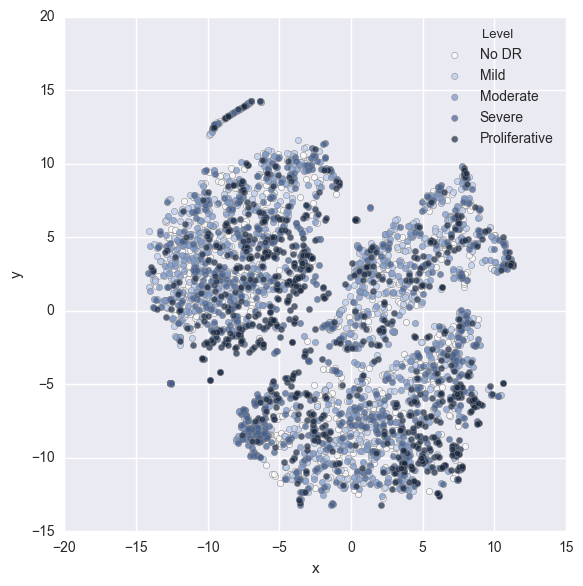

In [11]:
pal = sns.cubehelix_palette(n_colors=5, light=1.0, rot=0.0, start=2.8, hue=1.0)
sns.lmplot(data=df_tsne, x='x', y='y', hue='Level', 
           size=6, fit_reg=False, palette=pal, legend_out=False,
           scatter_kws={'s':20, 'edgecolors':'gray', 'linewidths':0.5, 'alpha':0.7});

# Holdout set
on the balanced data

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_bal, y_bal, test_size=0.3,
                                                                    stratify=y_bal, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2478, 2049), (2478,), (1062, 2049), (1062,))

# Logistic regression
Fit a simple logisitic regression model on the balanced data.

In [13]:
reg = linear_model.LogisticRegression(C=0.1) # 0.44
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.435969868173258

# Confusion matrix
Raw values

In [14]:
labels = [0,1,2,3,4]
cm = confusion_matrix(y_test, y_pred, labels=labels)
print(cm)

[[ 94  59  37  14   9]
 [ 68  72  47  16   9]
 [ 42  38  55  40  37]
 [ 14  29  28  95  47]
 [  7   5  14  39 147]]


Normalised to row sums

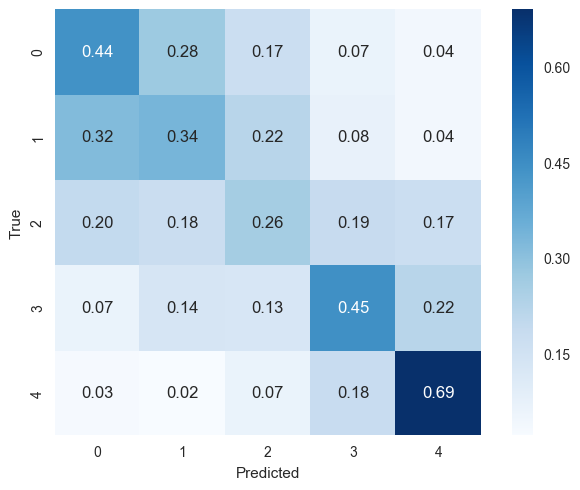

In [15]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, square=True, annot=True, fmt='0.2f',
            annot_kws={'fontsize':12}, cmap='Blues', 
            xticklabels=labels, yticklabels=labels);
plt.ylabel('True');
plt.xlabel('Predicted');

So the model manages to predict 69 % of proliferative DR correctly and only wrongly classifies 3 % of profliferative DR as no DR.